# Multi-Fidelity Bayesian Optimization: Investigating a Minimal Toy Problem

## Notes
We'll need to maintain a multioutput Gaussian Process surrogate for multifidelity Bayesian optimization. When using Gaussian Processes in the multifidelity scenario, one option is to extend the surrogate model through an autoregressive scheme:
$$
f^{(l)} = \rho f^{(l-1)}(\textbf{x}) + \delta^{l}(\textbf{x}), \;\; l = 2, \dots, L 
$$
where $\delta^{l}(\textbf{x}) \sim \mathcal{GP}(0, \kappa^{(l)}(\textbf{x}, \textbf{x}'))$ models the discrepancy between two adjoining levels of fidelity, and $\rho$ is a constant scaling factor.

## Desideratum
- [ ] We'll need a mechanism for computing covariances between input-fidelity pairs.
    - This poses a natural question: How do we choose our kernel function for evaluating the covariance between different fidelity levels?
- [x] Figure out if the white noise kernel is for ensuring the invertability of our linear system.
- [ ] Add support for optimize surrogates with arbitrary sum and product kernels.
    - The issue right now is that the constructor for each kernel needs to be provided to Optim and a manner that allows us to reconstruct the kernel iteratively for optimization

## Minimal Problem Exploration
To make sense of the methodology presented in `Non-Myopic Multifidelity Bayesian Optimization`, we'll reduce our problem to the simplest instance of the generalized problem. That is, we only consider two fidelity measures via the autoregressive scheme:
$$
    f^{(2)} = \rho f^{(1)}(\textbf{x}) + \delta^{2}(\textbf{x})
$$

Given some arbitrary $\textbf{x}$, we know our 

## Surrogate and Kernel Setup

In [6]:
using DelimitedFiles

In [7]:
include("../src/mfbo.jl")

optimize_surrogate (generic function with 1 method)

## 1. Gather Initial Samples
Our first step is to run some initial experiments and collect our data locations into some matrix $X$ and observations into some vector $y$. Our "experiments" will be random evaluations of some test function; in practice, our function is black-boxed.

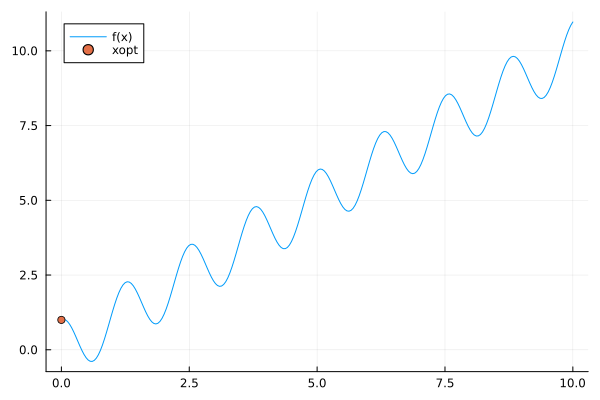

In [8]:
N, ϵ = 2, 1e-6
# testfn, testfn_name, X, y = get_toy_problem(N=N, fn_name="Ackley1D")
testfn = TestLinearPlusCosine1D(1., 5., lb=0., ub=10.)
X = randsample(N, testfn.dim, testfn.bounds[:, 1], testfn.bounds[:, 2])
y = testfn(X) .+ ϵ * randn(N)
tplot(testfn)

## 2. Initialize the surrogate model

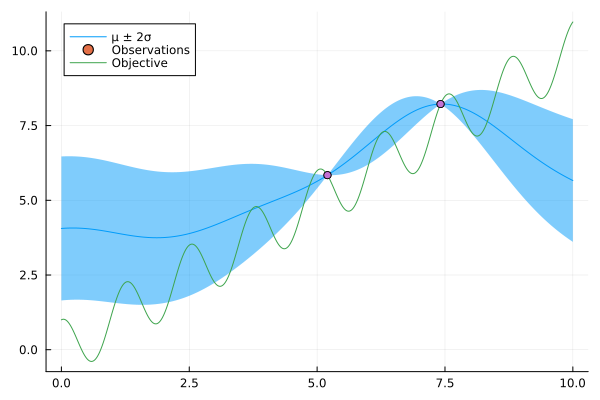

In [9]:
kernel = SquaredExponential() + Periodic()
sur = optimize_surrogate(
    gp=GP(kernel, X, y, noise=ϵ),
    kernel_expression_tree=kernel,
    lbs=.1 * ones(length(kernel)),
    ubs=10. * ones(length(kernel)),
    noise=ϵ,
    random_restarts=12,
    optim_options=Optim.Options(iterations=20)
)


if testfn.dim == 1
    domain = get_dense_grid(testfn)
    plot1d(sur, interval=domain)
    plot!(domain, [testfn([x]) for x in domain], label="Objective")
    scatter!(sur.X', get_observations(sur), label=nothing)
else
    xx = range(testfn.bounds[1,1], testfn.bounds[1,2], length=100)
    yy = range(testfn.bounds[2,1], testfn.bounds[2,2], length=100)
    plot(xx, yy, (x,y) -> sur([x, y])[1], st=:contour)
end

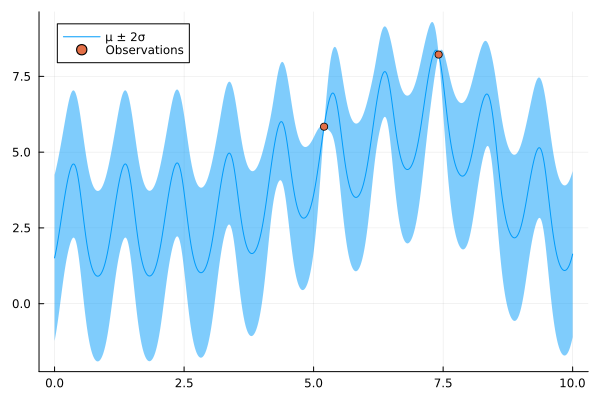

In [10]:
bsur = BoundedGP(kernel, X, y, noise=ϵ, capacity=4);
domain = get_dense_grid(testfn)

plot1d(bsur, interval=domain)

## Gaussian Process Regression for Nonlinear Time Series

In [8]:
data = readdlm("../data/co2_mm_mlo.csv", ',');

year, month, co2 = data[2:end, 1], data[2:end, 2], data[2:end, 4];
year_month = similar(year)

# Combine year and month into a single variable where the fractional part of
# the variable represents the month
for (i, payload) in enumerate(zip(year, month))
    cur_year, cur_month = payload
    year_month[i] = cur_year + cur_month / 12.
end

xtrain = year_month[year_month.<2018]; ytrain = co2[year_month.<2018];
xtest = year_month[year_month.>=2018]; ytest = co2[year_month.>=2018];

## On Modeling Separable Gaussian Processes via Additive Kernels
Given a random process $f(x) = f_1(x) + f_2(x)$, where $f_1, f_2$ are independent, then $k(x, y) = k_1(x, y) + k_2(x, y)$. Given a kernel $k: \chi^2 \to \mathbb{R}$ where $\chi \subset \mathbb{R}^d$ we know that adding a kernel or multiplying by a kernel results in another kernel.

In [12]:
kernels = [
    SquaredExponential(.5),
    Periodic(1., 1.1),
    Periodic(.5, .5),
]
kernel = sum(kernels)
surs = []
noise = 1e-4

sur = GP(kernel, X, y; noise=noise);